In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import struct
import bz2
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import data, img_as_float
import scipy
import glob

C:\Users\Chenyu\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Read registered experiment data

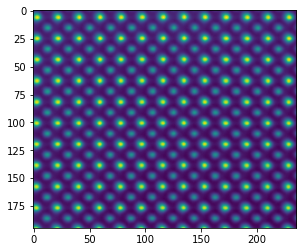

In [202]:
# Process registered data and crop it
path = 'D:/2020/TitanCalibration/072320/072320_Calibration/S6_14.5MX_SS9/'
path_img = path + 'average.q2bz'
img = LoadImage(path_img)
path_nSamples = path + 'numSamples.q2bz'
nSamples = LoadImage(path_nSamples)
img_crop = nSamplesCrop(img, nSamples)
plt.imshow(img_crop)

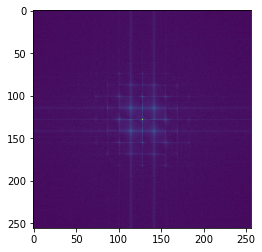

In [123]:
temp = np.fft.fft2(img)
temp = np.fft.fftshift(temp)
temp = (np.abs(temp))
plt.imshow(np.sqrt(np.sqrt(temp)))
plt.imsave(path + 'FFT.tiff', np.sqrt(np.sqrt(temp)), cmap='gray')

In [63]:
plt.imsave('D:/2020/TitanCalibration/062520_Calibration/CollectionAngles/DetectorScan.tiff', DetectorScan, cmap='gray')

20805.490530860563


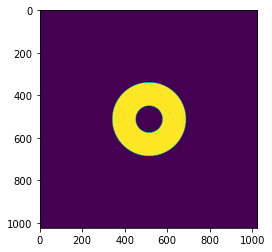

In [81]:
plt.imshow(mask2&~mask1)
BeamLevel = DetectorScan[mask2&~mask1].mean()
print(BeamLevel)

5109.7037037037035
28366.729381316847


(-0.5, 235.5, 194.5, -0.5)

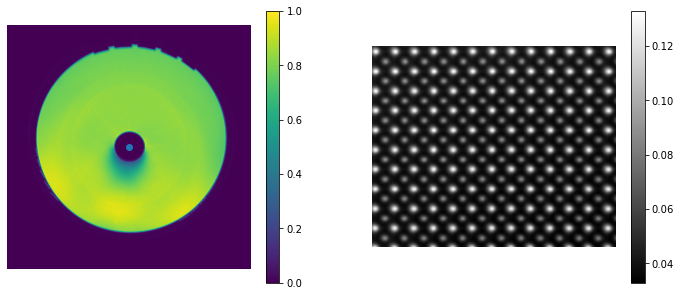

In [203]:
# Process HAADF detector scan to get beam and dark level
DetectorScan = np.load('D:/2020/TitanCalibration/072320/072320_Calibration/DetectorScan.npy')
# Use center part to extract dark level
center = [512,512]
mask = create_circular_mask(DetectorScan.shape[0],DetectorScan.shape[1], center, 5)
mask1 = create_circular_mask(DetectorScan.shape[0],DetectorScan.shape[1], center, 63)
mask2 = create_circular_mask(DetectorScan.shape[0],DetectorScan.shape[1], center, 173)
DarkLevel = DetectorScan[np.nonzero(DetectorScan*mask)].mean()
print(DarkLevel)
# Use the whole detector to calculate beam level
# intensity = 10000 is used as a threshold for the detector area
BeamLevel = DetectorScan[np.nonzero(np.heaviside(DetectorScan-10000,0))].mean()
BeamLevel = DetectorScan[mask2&~mask1].mean()
print(BeamLevel)
# BeamLevel = 18313
# DarkLevel = 5109
img_crop_quant = (img_crop - DarkLevel) / (BeamLevel - DarkLevel)
fig = plt.figure(figsize=(12,5))
fig.add_subplot(121)
plt.imshow(DetectorScan)
plt.scatter(512,512)
plt.colorbar()
plt.axis('off')
fig.add_subplot(122)
plt.imshow(img_crop_quant,cmap='gray')
plt.colorbar()
plt.axis('off')

## Read simulation data from old Prismatic

In [12]:
f.close()

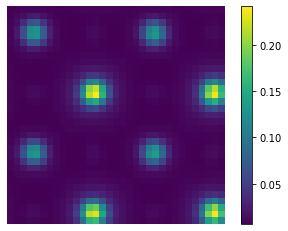

In [88]:
plt.imshow(HAADF_stack[:,:,20])
plt.axis('off')
plt.colorbar()

## Read simulation data
Prismatic simulation:
<br>20 frozen phonon configurations
<br>9x9x26 uc STO model
<br>7 A simulation window
<br>0.02 A pixel size in real space potential, 313 mrad simulation limit in k-space
<br>Output every 2 slices = 1 unit cell

In [11]:
# Generate HAADF image stack from different thickness
f = h5py.File('D:/2020/TitanCalibration/STO_HAADFsim_3Doutput/STO_3D.h5')
dataset = f['4DSTEM_simulation']['data']['realslices']['virtual_detector_depth0000']['realslice']
HAADF_stack = np.zeros((dataset.shape[0], dataset.shape[1], len(f['4DSTEM_simulation']['data']['realslices'].keys())))
# Generate HAADF image from 50-308 mrad
for idepth in range(len(f['4DSTEM_simulation']['data']['realslices'].keys())):
    slice_name = 'virtual_detector_depth' + '{0:04d}'.format(idepth)
    dataset = f['4DSTEM_simulation']['data']['realslices'][slice_name]['realslice']
    HAADF_stack[:,:,idepth] = np.sum(dataset[:,:,50:139],axis=2)

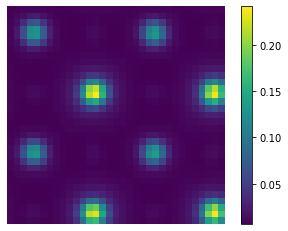

In [12]:
plt.imshow(HAADF_stack[:,:,20])
plt.axis('off')
plt.colorbar()

## Thickness measurement using integrated intensity

(array([-0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,
         0.08]), <a list of 10 Text major ticklabel objects>)

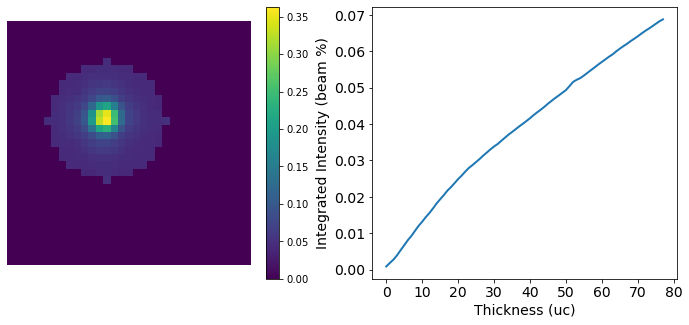

In [204]:
# Calculate relationship between integrated intensity and thickness using simulated Sr intensity
Sr_peak = [13,13]
radius = 8
Sr_mask = create_circular_mask(HAADF_stack.shape[0], HAADF_stack.shape[1], center=Sr_peak, radius=radius)
intensity_list = np.zeros(HAADF_stack.shape[2])
for i in range(HAADF_stack.shape[2]):
    intensity_list[i] = np.sum(Sr_mask * HAADF_stack[:,:,i] / np.sum(Sr_mask))

fig = plt.figure(figsize=(12,5))
fig.add_subplot(121)
plt.imshow(Sr_mask * HAADF_stack[:,:,i])
plt.colorbar()
plt.axis('off')
fig.add_subplot(122)
plt.plot(intensity_list, linewidth=2)
plt.xlabel('Thickness (uc)',fontsize=14)
plt.ylabel('Integrated Intensity (beam %)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

Average integrated intensity around Sr: 0.0564
Correspond to thickness in unit cell: 60


(-0.5, 235.5, 194.5, -0.5)

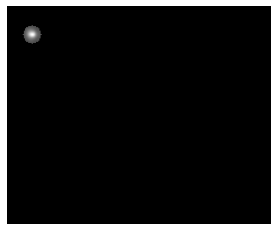

In [205]:
# process experiment data to determine the thickness
im = img_crop_quant
image_max = ndi.maximum_filter(im, size=25, mode='constant')
coordinates = peak_local_max(im, min_distance=10)
integrated_int = 0
for i in range(coordinates.shape[0]):
    # mask center is in the order of [x,y], detected coordinates are in pair of [y,x], so it needs to be rearranged
    center = [coordinates[i,1],coordinates[i,0]]
    Sr_mask = create_circular_mask(im.shape[0], im.shape[1], center=center, radius=radius)
    integrated_int = integrated_int + (np.sum(Sr_mask * im) / np.sum(Sr_mask))
    
integrated_int = integrated_int / coordinates.shape[0]
index = np.argmin(np.abs(intensity_list - integrated_int))

# Report results
print('Average integrated intensity around Sr: ' + '{0:0.4f}'.format(integrated_int))
print('Correspond to thickness in unit cell: ' + '{0:0d}'.format(index+1))
plt.imshow((im * Sr_mask), cmap=plt.cm.gray)
plt.axis('off')
# plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')

## Match the whole image after Gaussian convolution

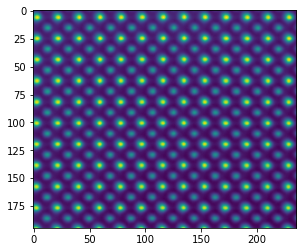

In [206]:
plt.imshow(img_crop_quant)

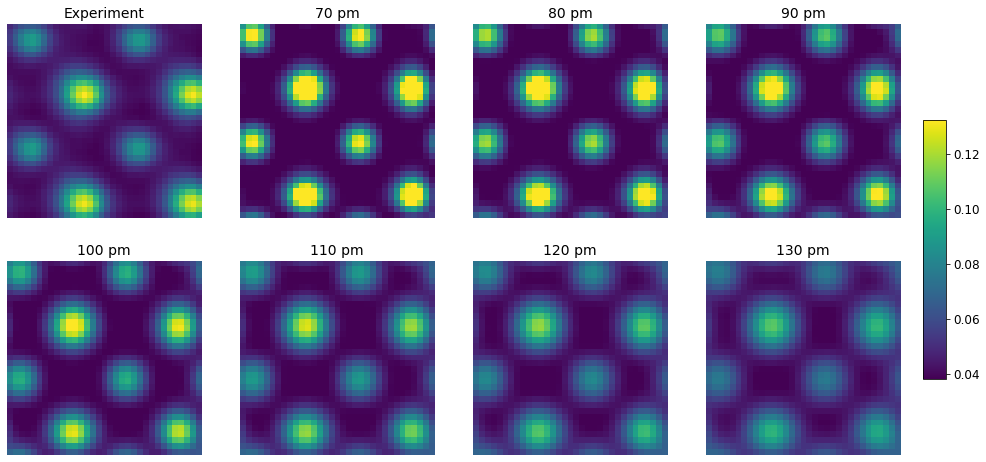

In [230]:
# pixel size used in both simulation and experiment
px_size = 21.5
img_patch_quant = img_crop_quant[70:104,102:136]
img_patch_quant = img_crop_quant[13:47,9:43]
# img_patch_quant = img_crop_quant[17:51,11:45]
# Plot quantitative STEM data, all images use the same colorbar
int_max = np.amax(img_patch_quant)
int_min = np.amin(img_patch_quant)

fig = plt.figure(figsize=(16,8))
fig.add_subplot(241)
im = plt.imshow(img_patch_quant,clim=[int_min, int_max])
plt.axis('off')
plt.title('Experiment',fontsize=14)

# Plot a series of simulations convoluted with different source sizes
for i in range(7):
    
    source_size = 70 + i*10
    sigma = (source_size/px_size)/(2.355)
    kernel = gaussKernel(sigma,HAADF_stack.shape[0])
    fkernel = np.fft.fft2(kernel)
    sim_ss = np.fft.fftshift(np.fft.ifft2(fkernel*np.fft.fft2(HAADF_stack[:,:,index]))).real
    
    fig.add_subplot(2,4,i+2)
    plt.imshow(sim_ss,clim = [int_min, int_max])
    plt.axis('off')
    plt.title('{0:0d}'.format(source_size) + ' pm', fontsize=14)

cax = fig.add_axes([0.92,0.26,0.02,0.45])
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12)

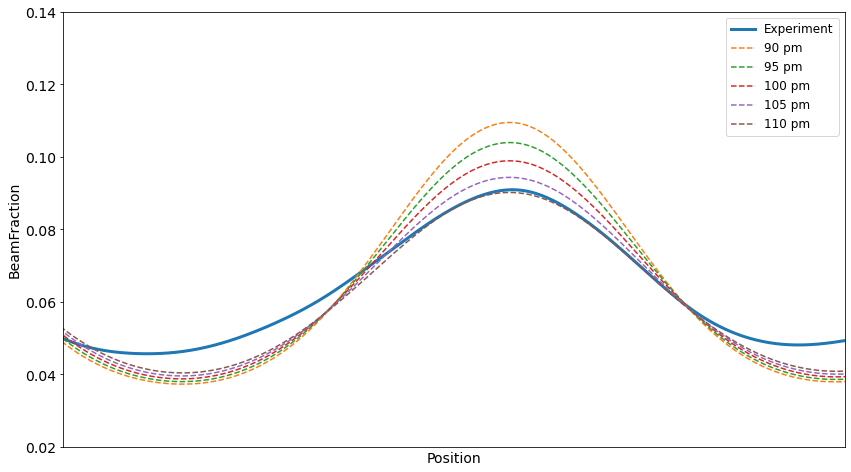

In [235]:
#-- Extract the line...

# Make a line with "num" points...
x0, y0 = 16, 12# These are in _pixel_ coordinates!!
x1, y1 = x0+33, y0+33
num = 1000
img_patch_quant = img_crop_quant[x0:x1,y0:y1]
x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)

# Extract the values along the line, using cubic interpolation
zi = scipy.ndimage.map_coordinates(img_crop_quant, np.vstack((x,y)))

#-- Plot...
# fig = plt.figure(figsize=(16,8))
# fig.add_subplot(221)
# plt.imshow(img_patch_quant)
# plt.plot([0,32], [0,32], 'ro-')
# plt.axis('off')

# fig.add_subplot(212)
fig = plt.figure(figsize=(14,8))
plt.plot(zi+0.004,linewidth=3 ,label = 'Experiment')
x0, y0 = 0.85, 0.85 # These are in _pixel_ coordinates!!
x1, y1 = x0+33, y0+33
num = 1000
x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
for i in range(5):
    
    source_size = 90 + i*5
    sigma = (source_size/px_size)/(2.355)
    kernel = gaussKernel(sigma,HAADF_stack.shape[0])
    fkernel = np.fft.fft2(kernel)
    sim_ss = np.fft.fftshift(np.fft.ifft2(fkernel*np.fft.fft2(HAADF_stack[:,:,index]))).real
    zj = scipy.ndimage.map_coordinates(sim_ss, np.vstack((x,y)))
    plt.plot(zj-0.0, '--',label= '{0:0d}'.format(source_size) + ' pm')

plt.legend(fontsize=12)
plt.xticks([])
plt.xlabel('Position',fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('BeamFraction',fontsize=14)
plt.xlim([400,700])
plt.ylim([0.02,0.14])

plt.show()

['D:/2020/TitanCalibration/062520_Calibration/CollectionAngles\\Apt30_innerEdge_1.mrc', 'D:/2020/TitanCalibration/062520_Calibration/CollectionAngles\\Apt30_innerEdge_2.mrc', 'D:/2020/TitanCalibration/062520_Calibration/CollectionAngles\\Apt30_innerEdge_3.mrc', 'D:/2020/TitanCalibration/062520_Calibration/CollectionAngles\\Apt30_innerEdge_4.mrc', 'D:/2020/TitanCalibration/062520_Calibration/CollectionAngles\\Apt30_innerEdge_5mrc.mrc', 'D:/2020/TitanCalibration/062520_Calibration/CollectionAngles\\Apt30_innerEdge_6.mrc']


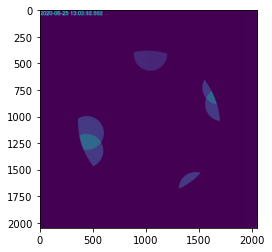

In [22]:
path = 'D:/2020/TitanCalibration/062520_Calibration/CollectionAngles/Apt30_innerEdge*.mrc'
filelist = glob.glob(path)
print(filelist)
image = np.zeros(2048)
for i in range(len(filelist)):
    image = image + loadMRCfile(filelist[i])
plt.imshow(image)
plt.imsave('D:/2020/TitanCalibration/062520_Calibration/CollectionAngles/DetectorEdge.tiff', image, cmap='gray')
# image = loadMRCfile(filepath)

## Functions

In [3]:
def nSamplesCrop(img, nSamples):
    nSamples = np.heaviside(nSamples-np.amax(nSamples),1)
    index = np.where(nSamples==1)
    img_crop = img[np.min(index[0]):np.max(index[0]),np.min(index[1]):np.max(index[1])]
    return img_crop

In [4]:
def LoadImage(path):
    # read header in read text mode
    fid = bz2.open(path, mode='rt',encoding = "ISO-8859-1")
    next(fid)    # magic number P9, skip
#     print(fid.readline())   # description line
    fid.readline()
    size = fid.readline()   # image size in width, height
    width = int(size.split(' ')[0])
    height = int(size.split(' ')[1][:-1])
#     print(width, height)
#     print(fid.readline())   # max?
    # each number is a 8 byte double format

    # read data part in read binary mode
    img = np.zeros((height,width))
    fid = bz2.open(path, mode='rb')
    for _ in range(4):
        next(fid)
    for icol in range(width):
        for irow in range(height):
            read_bytes = fid.read(8)
            img[irow,icol] = struct.unpack('d',read_bytes)[0]

    return img

In [5]:
def LoadNumSamples(path):
    # crop image accroding to numsamples
    # read header in read text mode
    fid = bz2.open(path, mode='rt',encoding = "ISO-8859-1")
    next(fid)    # magic number P9, skip
    # print(fid.readline())   # description line
    fid.readline()
    size = fid.readline()   # image size in width, height
    width = int(size.split(' ')[0])
    height = int(size.split(' ')[1][:-1])
    # print(width, height)
    # print(fid.readline())   # max?
    # each number is a 8 byte double format

    # read data part in read binary mode
    nSamples = np.zeros((height,width))
    fid = bz2.open(path, mode='rb')
    for _ in range(4):
        next(fid)
    for icol in range(width):
        for irow in range(height):
            read_bytes = fid.read(8)
            nSamples[irow,icol] = struct.unpack('d',read_bytes)[0]

    nSamples = np.heaviside(nSamples-np.amax(nSamples),1)

    return nSamples

In [6]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [7]:
def gaussKernel(sigma,imsize):
    x,y = np.meshgrid(range(1,imsize+1),range(1,imsize+1))
    x = x - imsize//2
    y = y - imsize//2
    tmp = -(x**2+y**2)/(2*sigma**2)
    return (1/(2*np.pi*sigma**2))*np.exp(tmp)

In [8]:
def loadMRCfile(filepath):
    with open(filepath, mode='rb') as file: # b is important -> binary
        file.seek(0)
        read_bytes = file.read(8)
        frame_width = struct.unpack('<i',read_bytes[0:4])
        frame_width = frame_width[0]
        frame_height = struct.unpack('<i',read_bytes[4:8])
        frame_height = frame_height[0]
        image = np.zeros((frame_height,frame_width))
        file.seek(256*4)
        dataset = file.read(frame_width*frame_height*4)
        for irow in range(frame_height):
            for icol in range(frame_width):
                pixel = struct.unpack('<f',dataset[(irow*frame_width+icol)*4:(irow*frame_width+icol+1)*4])[0]
                image[irow,icol] = pixel
        return image

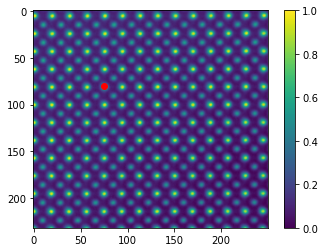

In [185]:
# Compare data acquired with spot size 9 and 10
# Spot size 10
path = 'D:/2020/TitanCalibration/072320/072320_Calibration/S5_14.5MX_SS10/'
path_img = path + 'average.q2bz'
img = LoadImage(path_img)
path_nSamples = path + 'numSamples.q2bz'
nSamples = LoadImage(path_nSamples)
img_crop = nSamplesCrop(img, nSamples)
DarkLevel = 5111.580246913581
BeamLevel = 18313
img_crop_quant_ss10 = (img_crop - DarkLevel) / (BeamLevel - DarkLevel)
plt.imshow(img_crop_quant_ss10)
plt.scatter(75,80,color='r')
plt.colorbar()

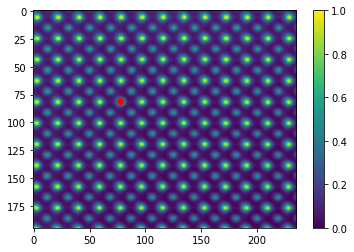

In [186]:
# Spot size 9
# Process registered data and crop it
path = 'D:/2020/TitanCalibration/072320/072320_Calibration/S6_14.5MX_SS9/'
path_img = path + 'average.q2bz'
img = LoadImage(path_img)
path_nSamples = path + 'numSamples.q2bz'
nSamples = LoadImage(path_nSamples)
img_crop = nSamplesCrop(img, nSamples)
DarkLevel = 5109.7037037037035
BeamLevel = 28366.729381316847
img_crop_quant_ss9 = (img_crop - DarkLevel) / (BeamLevel - DarkLevel)
plt.imshow(img_crop_quant_ss9)
plt.scatter(77,81,color='r')
plt.colorbar()

(-0.5, 32.5, 32.5, -0.5)

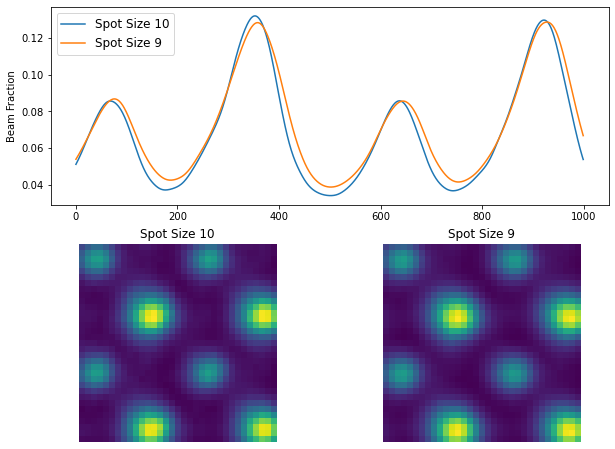

In [187]:
# Spot size 10 case
x0, y0 = 70, 83 # These are in _pixel_ coordinates!!
x1, y1 = x0+33, y0+33
num = 1000
img_patch_quant_ss10 = img_crop_quant_ss10[x0:x1,y0:y1]
x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)

# Extract the values along the line, using cubic interpolation
z10 = scipy.ndimage.map_coordinates(img_crop_quant_ss10, np.vstack((x,y)))

# Spot size 9 case
x0, y0 = 70, 85 # These are in _pixel_ coordinates!!
x1, y1 = x0+33, y0+33
num = 1000
img_patch_quant_ss9 = img_crop_quant_ss9[x0:x1,y0:y1]
x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)

z9 = scipy.ndimage.map_coordinates(img_crop_quant_ss9, np.vstack((x,y)))

fig = plt.figure(figsize=(10,8))
plt.subplot(211)
plt.plot(z10,label = 'Spot Size 10')
plt.plot(z9, label = 'Spot Size 9')
plt.legend(fontsize=12)
plt.ylabel('Beam Fraction')

plt.subplot(223)
plt.imshow(img_patch_quant_ss10)
plt.title('Spot Size 10')
plt.axis('off')

plt.subplot(224)
plt.imshow(img_patch_quant_ss9)
plt.title('Spot Size 9')
plt.axis('off')